In [8]:
import struct
import matplotlib.pyplot as plt
import numpy as np


f=open('10_11_2024a01.D24','rb')
file=f.read()



In [9]:

def search (data,format:str,start:int,end:int,size:int):
    '''Extrae la información de un archivo en binario, se debe indicar el tipo de 
    datos "format" y el tamaño, en bytes, del tipo de dato "size". '''
    list=[]
    position=-1
    for byte in data[start:end+1]:
        position+=1 
        if position%size==0:
           i=position+start
           val=(struct.unpack(format,data[i:i+size]))[0]
           list.append(val)
        else:
           continue     
    return list


In [10]:
def header (data):
    '''Extrae la información del header de lor archivos de collect y la almacena en un diccionario.
    Requiere la función search()'''
    note_list=search(file,'c',28,106,1)    
    note=''    
    for letter in note_list:
        if letter == b'\x00':
            break
        str_letter=letter.decode('ascii')
        note+=str_letter  
    header= {
        'nch': (struct.unpack('b',data[:1]))[0], #numero de canales
        'gain': search(data,'b',1,4,1), #ganancia en cada canal
        'global_freq': struct.unpack('f',data[5:9])[0],
        'eq_freq': struct.unpack('b',data[9:10])[0], #frecuencia igual/desigual
        't_points': int(struct.unpack('f',data[10:14])[0]), #número total de puntos
        'ad_resol': struct.unpack('b',data[14:15])[0],  #Resolución análogo digital
        'aux_channel':struct.unpack('b',file[111:112])[0],
        'aux_val':search(file,'f',112,127,4),
        'note':note,
    }
    return header


In [11]:

def points (file):
    '''Extrae todos los puntos, registrados por el sensor AD, de un archivo de collect,
    los situa en el offset y los guarda en una lista. Requiere la función header()'''
    head=header(file)
    raw_points=search(file,'H',128,128+head['t_points']*2,2) #t_points*2, porque mide 2 bytes cada punto
    zero=2**(head['ad_resol']-1)
    offset_points=[(point-zero)/(zero/10) for point in raw_points]
    return offset_points


In [12]:
'''Se podría generar primero la función de equal o unequal y luego dentro 
de la función de channels crear la lista de listas/canales
Asumiendo que ya están las listas'''

def eq_channels (offset_points:list,head:dict,channels:list):
    '''Toma todos los puntos extraídos de un archivo de collect y los organiza en 
    la lista 'channels' con igual frecuencia para todos. Requiere el header como dato de entrada'''
    count=1
    for point in offset_points: #agregando cada punto a su canal correspondiente
        channels[count-1].append(point/(head['gain'][count-1])) #al agregarlo se hace la conversión del punto para que coincida con el valor real en voltios
        if count==head['nch']:
            count=1
        else:
            count+=1
    return channels


In [13]:


def channels_points(file):
    '''Crea una lista de canales y organiza los puntos tomados del archivo de collect asignando cada uno a 
    su canal correspondiente. Grafica los resgistros'''
    head=header(file)
    offset_points=points(file)
    channels=[]
    times=[]
    ch_count=list(range(head['nch']))
    for channel in ch_count:#Creando lista de canales y de tiempos
        channels.append([])
        times.append([])
    channels=eq_channels(offset_points,head,channels) #agregando los puntos a los canales/eq_frequency        
    for time in ch_count:#creando array de tiempos para cada canal
        for point in list(range(len(channels[time]))):         
            times[time].append(point/head['global_freq'])
    fig, ax = plt.subplots(head['nch'])
    for channel in ch_count:           
        ax[channel].plot(times[channel],channels[channel])
        #ax.set_xlabel('Time(s)')
        #ax.ser_ylabel('Voltage(V)')
    return channels,times





([[0.38604736328125,
   0.40496826171875,
   0.43609619140625,
   0.48980712890625,
   0.498046875,
   0.50323486328125,
   0.5072021484375,
   0.52490234375,
   0.5548095703125,
   0.56732177734375,
   0.60272216796875,
   0.61553955078125,
   0.6182861328125,
   0.62530517578125,
   0.634765625,
   0.66497802734375,
   0.679931640625,
   0.706787109375,
   0.71197509765625,
   0.72540283203125,
   0.78582763671875,
   0.8038330078125,
   0.8221435546875,
   0.843505859375,
   0.8721923828125,
   0.89080810546875,
   0.9149169921875,
   0.95062255859375,
   0.97564697265625,
   1.0089111328125,
   1.02447509765625,
   1.06597900390625,
   1.07879638671875,
   1.10595703125,
   1.12152099609375,
   1.15020751953125,
   1.1773681640625,
   1.2158203125,
   1.22772216796875,
   1.24114990234375,
   1.282958984375,
   1.34490966796875,
   1.39617919921875,
   1.44622802734375,
   1.43951416015625,
   1.4752197265625,
   1.4825439453125,
   1.49139404296875,
   1.53350830078125,
   1.55761

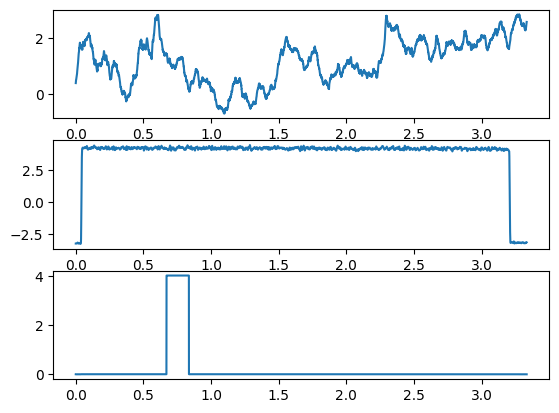

In [14]:
channels_points(file)